In [1]:

import multiprocessing
print(multiprocessing.cpu_count())

import psutil
print(f"Available memory before training: {psutil.virtual_memory().available / 1e9:.2f} GB")

12
Available memory before training: 8.63 GB


In [2]:

import numpy as np
import pandas as pd
pd.set_option('display.max_info_columns', 200) #caps at 200, use None to show all
pd.set_option('display.max_rows', 200)

from my_utils import evaluate_and_save_pipeline

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
import joblib
import pickle

In [3]:

token = 'p22'
study = pd.read_pickle("p004_diabetes_MLprep.pkl")

for col in study.select_dtypes(include='int64'):
    study[col] = study[col].astype('int32')
    
print(study.shape)

(78743, 176)


In [4]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder 
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.metrics import accuracy_score as sklearn_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc

from sklearn.svm import LinearSVC

In [5]:

X = study.drop(['readmitted_ind'], axis=1)
y = study['readmitted_ind']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define features to EXCLUDE for training
exclude_features = ['patient_nbr', 'encounter_id', 'diagnosis_tuple', 'readmitted', 'dummy'] 
numeric_features = [col for col in X.columns if col not in exclude_features and X[col].dtype == 'int32']
object_features = [col for col in X.columns if col not in exclude_features and X[col].dtype == 'object']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore'), object_features)
    ])

In [6]:

%%time
linear_svc_l1 = LinearSVC(penalty='l1', dual=False, C=0.1, max_iter=100000, random_state=42)

LinearSVC = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(linear_svc_l1)),
    ('final_model', LinearSVC(penalty='l2', dual=True, C=1.0, max_iter=100000, random_state=42))  # Final model after selection
])

# Fit the pipeline
LinearSVC.fit(X_train, y_train)

with open(f"{token}_LinearSVC.pkl", "wb") as file:
    pickle.dump(LinearSVC, file)
print(f"Model saved as {token}_LinearSVC.pkl")


Model saved as p22_LinearSVC.pkl
CPU times: total: 4min 9s
Wall time: 4min 21s


In [7]:

# Get the selector and estimator from the pipeline
selector = LinearSVC.named_steps['feature_selector']
l1_model = selector.estimator_

# Get the mask of selected features
mask = selector.get_support()

# Get the fitted preprocessor and feature names
preprocessor = LinearSVC.named_steps['preprocessor']
num_features = preprocessor.named_transformers_['num'].get_feature_names_out(numeric_features)
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(object_features)
all_features = np.concatenate([num_features, cat_features])

# Get raw coefficients from the L1 model
coefs = l1_model.coef_.flatten()  # shape (n_features,) for binary classification

# Build full feature info dataframe
coef_df = pd.DataFrame({
    'feature': all_features,
    'coef': coefs,
})
coef_df['zero_ind'] = (coef_df['coef'] == 0).astype(int)
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df['gt1_ind'] = (coef_df['abs_coef'] > 1).astype(int)

# Filter to only selected features (non-zero coef)
selected_df = coef_df[mask].sort_values(by='abs_coef', ascending=False).reset_index(drop=True)
coef_df.to_csv(f'{token}_LinearSVC_coefficients.csv', index=False)

# View or save
print(f"🎯 Selected {len(selected_df)} features out of {len(coef_df)} total.")
print(selected_df.head(10))


🎯 Selected 128 features out of 231 total.
                  feature       coef  zero_ind   abs_coef  gt1_ind
0        number_inpatient -12.952286         0  12.952286        1
1     mb_readmitted_no_ct  -9.793891         0   9.793891        1
2            encounter_ct   6.523460         0   6.523460        1
3  mb_number_inpatient_ct   3.011166         0   3.011166        1
4     distinct_diag_count   2.197140         0   2.197140        1
5          dx_428_ind_sum  -1.648598         0   1.648598        1
6    mb_admission_type_ct   1.520631         0   1.520631        1
7          dx_403_ind_sum  -1.025150         0   1.025150        1
8   mb_readmitted_lt30_ct   0.992057         0   0.992057        0
9          dx_491_ind_sum  -0.562855         0   0.562855        0


Fits data saved as fits_pickle_p22_LinearSVC.pkl
Metrics saved to fits_pickle_p22_LinearSVC.pkl
MSE (Train): 0.0811
MSE (Test): 0.0815
R-sq (Train): 0.9189
R-sq (Test): 0.9185
Accuracy: 0.9185
accuracy_score: 0.9185
Sensitivity: 0.8632
Specificity: 0.9653


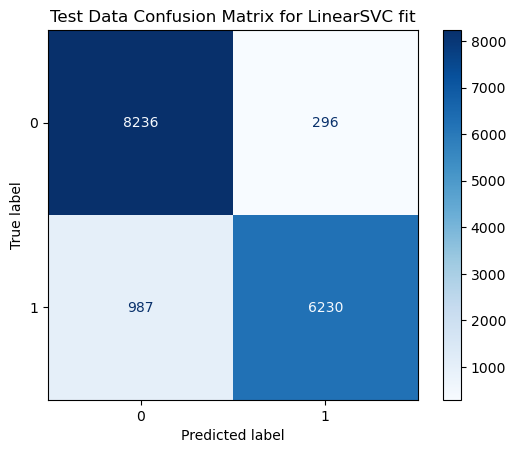

{'model_version': 'p22_LinearSVC',
 'mse_train': 0.08105533860367654,
 'mse_test': 0.08146548987237284,
 'r2_train': 0.9189446613963235,
 'r2_test': 0.9185345101276271,
 'y_test': array([0, 0, 0, ..., 0, 0, 1]),
 'y_train_pred': array([0, 0, 0, ..., 0, 0, 1]),
 'y_test_pred': array([0, 0, 0, ..., 0, 0, 0]),
 'display_labels': array([0, 1]),
 'tn': 8236,
 'fp': 296,
 'fn': 987,
 'tp': 6230,
 'sensitivity': 0.8632395732298739,
 'specificity': 0.9653070792311299,
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99859353, 0.99859353,
        1.        ]),
 'tpr': array([0.00000000e+00, 1.38561729e-04, 3.38090619e-02, ...,
        9.99861438e-01, 1.00000000e+00, 1.00000000e+00]),
 'thresholds': array([        inf, 13.68732005,  7.62332779, ..., -4.45920837,
        -4.47554943, -6.2264992 ]),
 'auc': 0.9836829272396315}

In [8]:

def evaluate_and_save_pipeline(pipeline, namestring, token, 
                               X_train, X_test, 
                               y_train, y_test):
    """
    Evaluates a trained pipeline and saves metrics to a pickle file.
    """

    # Properly check for missing inputs
    if any(v is None for v in [X_train, X_test, y_train, y_test]):
        raise ValueError("X_train, X_test, y_train, or y_test must not be None.")

    # Ensure data is in expected format (convert to numpy if necessary)
    y_train = y_train.values if hasattr(y_train, "values") else y_train
    y_test = y_test.values if hasattr(y_test, "values") else y_test

    # Make predictions
    y_test_pred = pipeline.predict(X_test)
    y_train_pred =  pipeline.predict(X_train)
    
    # Determine if model supports predict_proba or decision_function
    if hasattr(pipeline, "predict_proba"):
        y_test_pred_pct = pipeline.predict_proba(X_test)[:, 1]
    elif hasattr(pipeline, "decision_function"):
        y_test_pred_pct = pipeline.decision_function(X_test)
    else:
        raise AttributeError("🚨 This pipeline has neither predict_proba() nor decision_function(). Cannot generate continuous scores for ROC/AUC.")

    # Calculate metrics
    mse_train = mean_squared_error(y_train, pipeline.predict(X_train))
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_train = pipeline.score(X_train, y_train)
    r2_test = pipeline.score(X_test, y_test)

    # Confusion matrix & sensitivity/specificity
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    accuracy = (tn+tp)/ (tn+tp+fn+fp)
    accuracy_score = sklearn_accuracy_score(y_test, y_test_pred) 
    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_pct)
    roc_auc = auc(fpr, tpr)

    # Save metrics
    pickle_metrics = {
        'model_version': f"{token}_{namestring}",
        'mse_train': mse_train,
        'mse_test': mse_test,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'y_test': y_test,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred,
        'display_labels': pipeline.classes_ ,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'auc': roc_auc
    }
    
    filename = f"fits_pickle_{token}_{namestring}.pkl"
    with open(filename, "wb") as file:
        pickle.dump(pickle_metrics, file)
    print(f"Fits data saved as {filename}")

    # Print summary
    print(f"Metrics saved to {filename}")
    print('MSE (Train):',  round(mse_train,4))
    print('MSE (Test):',   round(mse_test, 4))
    print('R-sq (Train):', round(r2_train, 4))
    print('R-sq (Test):',  round(r2_test,  4))
    print('Accuracy:', round(accuracy, 4))
    print('accuracy_score:', round(accuracy_score,4))
    print('Sensitivity:', round(sensitivity,4))
    print('Specificity:', round(specificity,4))
    

    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Test Data Confusion Matrix for {namestring} fit")
    plt.show()

    return pickle_metrics
    
evaluate_and_save_pipeline(
    pipeline=LinearSVC, 
    namestring='LinearSVC',
    token=token, 
    X_train=X_train, 
    X_test=X_test, 
    y_train=y_train, 
    y_test=y_test)

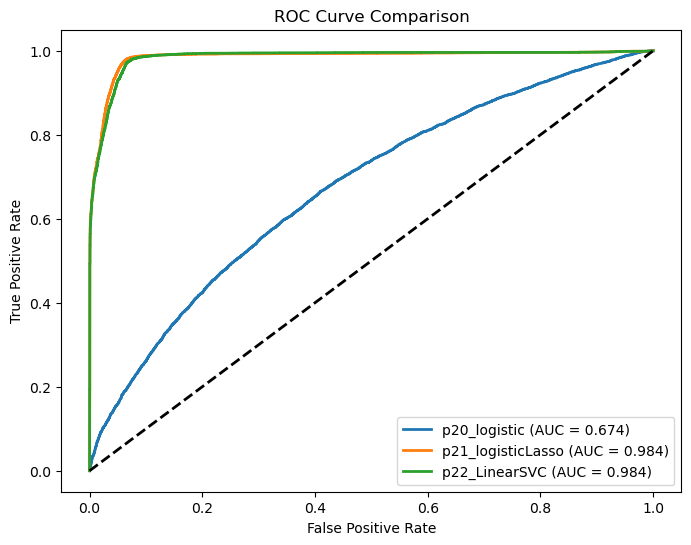

In [9]:

fits_pickles =['fits_pickle_p20_logistic.pkl'
             , 'fits_pickle_p21_logisticLasso.pkl'
             , 'fits_pickle_p22_LinearSVC.pkl']

colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
    '#bcbd22',  # lime
    '#17becf',  # cyan
    '#393b79',  # dark blue
    '#637939'   # dark green
]


def plot_roc_curves(fits_pickles):
    plt.figure(figsize=(8, 6))
    
    for i, file in enumerate(fits_pickles):
        model_data = pd.read_pickle(file)
        plt.plot(model_data['fpr'], model_data['tpr'], color=colors[i % len(colors)], lw=2, 
                 label=f"{model_data['model_version']} (AUC = {model_data['auc']:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Random baseline
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.show()

# Example usage:
# plot_roc_curves(['lasso_metrics.pkl', 'ridge_metrics.pkl'])
plot_roc_curves(fits_pickles)